Graph generation
===

"On average, most people have fewer friends than their friends have."

In [82]:
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

In [69]:
figures_dir = Path("../../images/graph_generation")
figures_dir.mkdir(exist_ok=True)

In [31]:
def investigate_friend_count(G: nx.Graph):
    degree_map = G.degree
    n_friends_have_more = 0
    n_friends_have_same = 0
    n_friends_have_less = 0
    for node, degree in degree_map:
        friend_count = degree
        friends = list(G.neighbors(node))
        assert len(friends) == friend_count
        n_same_count = 0
        n_more_than_friend_count = 0
        n_less_than_friend_count = 0
        for friend in friends:
            their_friends = degree_map[friend]
            if their_friends == friend_count:
                n_same_count += 1
            elif their_friends > friend_count:
                n_less_than_friend_count += 1
            elif their_friends < friend_count:
                n_more_than_friend_count += 1
        if n_less_than_friend_count > n_more_than_friend_count:
            n_friends_have_more += 1
        elif n_less_than_friend_count == n_more_than_friend_count:
            n_friends_have_same += 1
        elif n_less_than_friend_count < n_more_than_friend_count:
            n_friends_have_less += 1
    return n_friends_have_more, n_friends_have_same, n_friends_have_less
            
            
            

investigate_friend_count(G_er)

(57, 5, 38)

In [ ]:
# Erdős–Rényi (a.k.a. Gilbert G(n,p))
G_er = nx.erdos_renyi_graph(n=100, p=0.05)

# Watts–Strogatz small-world
G_ws = nx.watts_strogatz_graph(n=100, k=4, p=0.1)

# Barabási–Albert preferential attachment
G_ba = nx.barabasi_albert_graph(n=100, m=3)

# Holme–Kim preferential attachment with triadic closure
G_hk = nx.powerlaw_cluster_graph(n=100, m=3, p=0.3)

In [ ]:
for n in np.logra

In [100]:
ns = np.logspace(6, 11, base=2).astype(int)
n_samples = 7
ds = []

graph_funcs = {
    "Erdős–Rényi ($p$=5%)": lambda n: nx.erdos_renyi_graph(n=n, p=0.05),
    "Erdős–Rényi ($p$=10%)": lambda n: nx.erdos_renyi_graph(n=n, p=0.1),
    "Watts–Strogatz": lambda n: nx.watts_strogatz_graph(n=n, k=4, p=0.1),
    "Barabási–Albert": lambda n: nx.barabasi_albert_graph(n=n, m=3),
}

for n in tqdm(ns):
    for graph_name, graph_func in graph_funcs.items():
        for i in range(n_samples):
            G = graph_func(n)
            n_friends_have_more, n_friends_have_same, n_friends_have_less = investigate_friend_count(G)
            pct_more = n_friends_have_more / n
            ds.append({
                "graph_name": graph_name,
                "n": n,
                "i": i,
                "pct_more": pct_more,
            })
df = pd.DataFrame(ds)
df.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


(1400, 4)

In [97]:
df.groupby(["graph_name", "n"]).pct_more.mean().head(n=5)

graph_name       n 
Barabási–Albert  64    0.691964
                 68    0.674370
                 73    0.686888
                 79    0.678119
                 84    0.697279
Name: pct_more, dtype: float64

In [98]:
summary = (
    df.groupby(["graph_name", "n"])["pct_more"]
    .agg(["mean", "std", "count"])
    .assign(se=lambda d: d["std"] / np.sqrt(d["count"]))
)

# compute CI with scipy (normal approx)
alpha = 0.05
cis = scipy.stats.t.interval(1 - alpha, loc=summary["mean"], scale=summary["se"], df=summary["count"] - 1)
summary["ci_low"], summary["ci_high"] = cis
summary = summary.reset_index()
summary.head(1)

,graph_name,n,mean,std,count,se,ci_low,ci_high
0,Barabási–Albert,64,0.691964,0.021565,7,0.008151,0.67202,0.711908


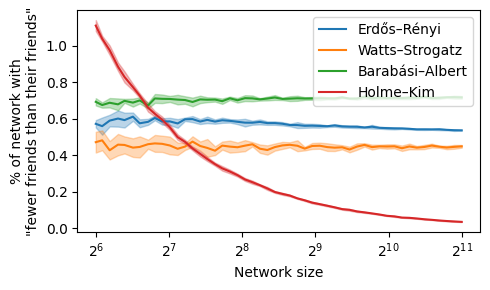

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for i, graph_name in enumerate(graph_funcs.keys()):
    sdf = summary[summary.graph_name == graph_name]
    ax.plot(sdf.n, sdf["mean"], color=f"C{i}", label=graph_name)
    ax.fill_between(sdf.n, sdf["ci_low"], sdf["ci_high"],
                    alpha=0.3, color=f"C{i}")

ax.set_xscale("log", base=2)
ax.set_xlabel("Network size")
ax.set_ylabel("% of network with\n\"fewer friends than their friends\"")
ax.legend()
fig.tight_layout()
fig.savefig(figures_dir / "er_size.svg", bbox_inches='tight', 
           facecolor='white', edgecolor='none', metadata={"Creator": "Zachary Levonian"}, transparent=False)
plt.show()